# K-Nearest Neighbors From Scratch: Proof of Concept
The purpose of this notebook is to demonstrate the simplicity and effectiveness of KNN classifier. This particular machine learning algorithm is extremely simple: In order to classify new observations, the algorithm calculates the distance from each observation you want to classify, to all other observations the classifier was "trained" on. One can use different distance metrics, but for this demonstration, I have the simple euclidean distance between the points we wish to classify and all other points in the training data. We then look at the K nearest points to each training point and let those K nearest neighbors vote on which class the new observations belong to, with the majority ruling. A basic example follows: Let K=3. If we wish to classify the point (p,q) in the (x,y) plane and the two nearest points in the training data belongs to class 1 but the third nearest neighbor belongs to class 2, then the point (p,q) is classified as belonging to class 1. 
 
There are two things worthy of noting with this algorithm: With huge datasets and many datapoints to classify, it is computationally inefficient to compute the distance between each observation to classify and all other datapoints in the training set. One can alleviate this issue by specifying a radius around each point and then only calculate the distance to other points within that radius, however, no such feature is implemented (or required) for this demonstration. Secondly, like with many other machine learning algorithms, it is a good idea to standardize data before fitting any model to it. However, this is also not necessary here, due to all features being in similar numerical ranges. 

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')

In [5]:
# Function to simulate some easy data 
def simulate_data(n, x, c):
    
    # n: how many samples (rows) 
    # x: how many features 
    # c: how many classes in our categorical response variable 
    
    df = pd.DataFrame(columns=[i for i in range(1,x+1)])
    df = df.add_prefix('X')
    
    for i, j in zip(df.columns, range(2,len(df.columns)+2)):
        df[i] = np.random.uniform(1, j*j, n)
    
    df['sum'] = df.sum(axis=1)
    df['Y'] = np.nan
    
    quantiles = np.arange(1/c, 1, 1/c)
    quantiles = quantiles[::-1]
    intervals = pd.qcut(df['sum'], c, retbins=True)[-1]
    
    
    for i, j in zip(intervals, range(1,c+1)):
        df['Y'] = np.where(df['sum'] >= i , j, df['Y'])
   
    df['Y'] = pd.to_numeric(df['Y'], downcast='integer')
    
    df.drop('sum', inplace=True, axis=1)
    
    return df


In [6]:
test = simulate_data(n=100, x=2,c=3)

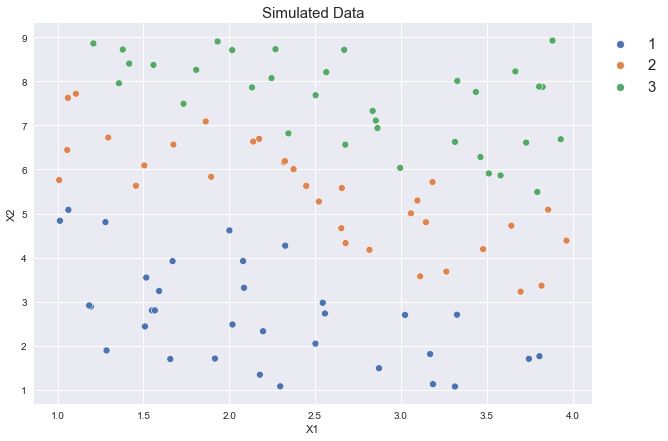

In [326]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=test, x='X1', y='X2', hue='Y', palette='deep')
plt.title('Simulated Data', fontdict={'fontsize':15})
plt.legend(fontsize=15, bbox_to_anchor=(1,1), loc=2)
plt.show()

This data is very clustered with rather clear borders between the clusters, but this is just for illustration purposes.

In [335]:
class KNNClassifier:
    
    def __init__(self, k, standardize=False):
        self.k = k
        self.standardize = standardize
        
    def fit(self, X, y):

        # pass training data (numpy arrays!) 
        
        self.X = X
        self.y = y
        
        if self.standardize == True:
            self.X = (self.X - np.mean(self.X, axis=0))
        
    def predict(self, p):
        
        # pass a list or numpy array
        # calculate euclidean distance to all points (RIP)
        
        self.p = p
        
        if isinstance(self.p, list): 
            self.p = np.array(p)
        
        self.distances = np.array([])
        for i in self.X:
            for j in self.p:
                self.dist = np.linalg.norm(i - j) 
                self.distances = np.append(self.distances, self.dist)
        
        self.distances = self.distances.reshape((self.X.shape[0], self.p.shape[0]))        
        
        self.result = np.array([])
        for i in self.distances.T:
            self.idx = np.argpartition(i, self.k)  #find the k smallest distances
            self.votes = self.y[self.idx[:self.k]]
            self.votes = Counter(self.votes)
            self.result = np.append(self.result, self.votes.most_common()[0][0])
            
        return self.result.astype(int)
    

In [328]:
X = test[['X1', 'X2']].values
y = test['Y'].values

In [329]:
a = [
    [1,1],
    [1,2],
    [1,3],
    [2,2],
    [4,9],
    [4,8]
]

model = KNNClassifier(k=3)
model.fit(X,y)
res = model.predict(p=a)

Looking at the scatterplot above, we clearly expect the first 4 datapoints to be classified as belonging to class 1 and the two last points to be classified as belonging to class 3

In [330]:
res

array([1, 1, 1, 1, 3, 3])

Seems to be working fine, but let's test the classifier on some real data that may not be as well-behaved as the simulated data. 

In [336]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)
dataset.dtypes

sepal-length    float64
sepal-width     float64
petal-length    float64
petal-width     float64
Class            object
dtype: object

 The classifier cannot deal with non-numerical classes, so we first have to encode the "Class" column into numerical values

In [337]:
dataset['Class'] = dataset['Class'].astype('category').cat.codes

In [338]:
dataset.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [339]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 4].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [340]:
model = KNNClassifier(k=10)
model.fit(X_train, y_train)
res = model.predict(p=X_test)

In [341]:
unique, counts = np.unique(res == y_test, return_counts=True)
dict(zip(unique, counts))

{True: 30}

The classifier had a 100% accuracy in this case, but the performance of the classifier is obviously conditional on the value we set for K, as the example below demonstrates:

In [344]:
model = KNNClassifier(k=100)
model.fit(X_train, y_train)
res = model.predict(p=X_test)

In [345]:
unique, counts = np.unique(res == y_test, return_counts=True)
dict(zip(unique, counts))

{False: 11, True: 19}

Since K is too high, we classified 11 points incorrectly, so some care has to be taken with setting this paramter.